In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import statsmodels.api as sm
import seaborn as sns
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 特征筛选
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression


from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import pearsonr

from sklearn import metrics

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR,LinearSVR,SVC
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier,ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
 

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


from functools  import reduce
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.model_selection import ShuffleSplit,cross_val_score

from sklearn.linear_model import SGDRegressor,ElasticNet
from sklearn.ensemble import BaggingRegressor,GradientBoostingClassifier,GradientBoostingClassifier
from sklearn.svm import NuSVR

from sklearn.metrics import r2_score

from scipy.stats import kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from numpy import *

colormap2 = "Blues"

In [2]:
ADMET_train = pd.read_excel("./ADMET.xlsx",sheet_name="training")
ADMET_test = pd.read_excel("./ADMET.xlsx",sheet_name="test")

activity_train = pd.read_excel("./ERα_activity.xlsx",sheet_name="training",)
activity_test = pd.read_excel("./ERα_activity.xlsx",sheet_name="test")

molecular = pd.read_excel("./Molecular_Descriptor.xlsx")
molecular_test = pd.read_excel("./Molecular_Descriptor.xlsx",sheet_name="test")

desc_summary = pd.read_excel("./分子描述符含义解释.xlsx",sheet_name="Summary")
desc_detail = pd.read_excel("./分子描述符含义解释.xlsx",sheet_name="Detailed")

desc_detail2 = desc_detail.fillna(method="ffill",axis=0)    # 填充

In [3]:
concat_testdata = pd.merge(left=molecular_test,right=activity_test,how="inner",on="SMILES")
testrawdata = concat_testdata.drop("IC50_nM",axis=1)

concat_data = pd.merge(left=molecular,right=activity_train,how="inner",on="SMILES")
rawdata = concat_data.drop("IC50_nM",axis=1)

In [4]:

concat_ADMET = pd.merge(left=molecular,right=ADMET_train,how="inner",on="SMILES").set_index("SMILES")
concat_ADMET_test = pd.merge(left=molecular_test,right=ADMET_test,how="inner",on="SMILES").set_index("SMILES")


In [5]:
# 判断是否有缺失值
rawdata.columns[rawdata.isnull().any()].tolist() # 无缺失值列
rawdata.columns[rawdata.isna().any()].tolist()  # 无缺失值列

isfinite = pd.Series(np.isfinite(rawdata.drop(labels=["SMILES"],axis=1)).all())
isfinite[isfinite == False]     # 无无穷列

isinf = pd.Series(np.isinf(rawdata.drop(labels=["SMILES"],axis=1)).all())
isinf[isinf == True]

# 删除全为一样的列
rawdata2 = rawdata.drop(rawdata.loc[:,rawdata.max(axis=0)==rawdata.min(axis=0)].columns,axis=1)


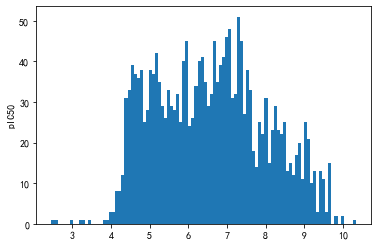

In [6]:
plt.hist(rawdata2.loc[:,"pIC50"],100)  # 因变量分布情况
plt.ylabel("pIC50")
plt.savefig("./output/因变量分布直方图.png",dpi=500, bbox_inches = "tight")
plt.show()

In [7]:
# # 查找可能呈现泊松分布的变量(考虑到变量含义为xxx次数、个数。不编码)

# freq_list = []
# for col in rawdata2.columns:
#     x = rawdata2.loc[:,col].value_counts().shape[0]
#     if x <=10:
# #         print(col,x)
#         freq_list.append(col)
    
# import re
# new_data_list = [] 
# for data in freq_list:  
#     if  re.match('n.*', data) == None:
#         new_data_list.append(data)
#         print(rawdata2.loc[:,data].value_counts())
        
# # 哑变量编码
# xx = pd.get_dummies(rawdata2.loc[:,new_data_list])

In [8]:
# 异常值判断
# outlierdata = rawdata2.copy()
# outlierlist1 = []
# outlierlist2 = []
# for c in outlierdata.columns.drop("SMILES"):
#     # 查找
#     mean1 = outlierdata[c].quantile(q=0.25)
#     mean2 = outlierdata[c].quantile(q=0.75)
#     mean3 = mean2 - mean1
#     topnum2 = mean2+3*mean3
#     bottomnum2 = mean2-3*mean3
# #     print("正常值的范围：",np.round(topnum2,1),np.round(bottomnum2,1))
# #     print("是否存在超出正常范围的值：",any(outlierdata[c]>topnum2))
# #     print("是否存在小于正常范围的值：",any(outlierdata[c]<bottomnum2))
# # or any(outlierdata[c] < bottomnum2)
#     if any(outlierdata[c]>topnum2) :
#         outlierlist1.append(c)
#     if any(outlierdata[c] < bottomnum2):
#         outlierlist2.append(c)
# print(outlierlist1)
# print(outlierlist2)


In [9]:
# # 对异常值变量分组绘图(未进行标准化数据)
# bins = 5
# cat = pd.qcut(rawdata2.loc[:,outlierlist1+outlierlist2].mean(axis=0),bins)
# cat2 = pd.DataFrame(cat,columns=["interval"])

# fig=plt.figure(figsize=(30,20))
# plt.rcParams['boxplot.flierprops.markersize'] = 4 # 默认为6
# for i in range(bins):
#     ax=fig.add_subplot(bins,1,i+1)
    
#     varlist = cat2.loc[cat2["interval"]==cat.value_counts().index[i],:].index
#     score_plotdata = train2.loc[:,varlist].melt()

# #     ax.boxplot(train2.loc[:,varlist])
    
#     color_p = sns.color_palette("Reds",9)
#     sns.boxplot(x="variable", y="value",data=score_plotdata)
    
#     ax.grid(linestyle="-.", axis='x', alpha=0.4)
#     ax.set_xticks([])
#     ax.set_ylabel(cat.value_counts().index[i])

# plt.subplots_adjust(wspace=0.1,hspace=0.05)
# plt.savefig("./output/变量箱线图可视化-数据标准化前.png",dpi=500, bbox_inches = "tight")
# plt.show()

In [10]:
# # 对异常值变量分组绘图(标准化后数据)
# zscore = preprocessing.StandardScaler()
# data_scale = zscore.fit_transform(rawdata2.drop(labels=["SMILES","pIC50"],axis=1))

# x_train = data_scale
# y_train = rawdata2.loc[:,"pIC50"].values

# features = rawdata2.drop(labels=["SMILES","pIC50"],axis=1).columns

# rawdata3 = pd.DataFrame(x_train,columns=features,index=rawdata2["SMILES"])
# rawdata3["pIC50"] = y_train

# bins = 5
# cat = pd.qcut(rawdata3.loc[:,outlierlist1+outlierlist2].mean(axis=0),bins)
# cat2 = pd.DataFrame(cat,columns=["interval"])

# fig=plt.figure(figsize=(30,20))
# plt.rcParams['boxplot.flierprops.markersize'] = 4 # 默认为6
# for i in range(bins):
#     ax=fig.add_subplot(bins,1,i+1)
    
#     varlist = cat2.loc[cat2["interval"]==cat.value_counts().index[i],:].index
#     score_plotdata = train2.loc[:,varlist].melt()

# #     ax.boxplot(train2.loc[:,varlist])
    
#     color_p = sns.color_palette("Reds",9)
#     sns.boxplot(x="variable", y="value",data=score_plotdata)
    
#     ax.grid(linestyle="-.", axis='x', alpha=0.4)
#     ax.set_xticks([])
#     ax.set_ylabel(cat.value_counts().index[i])

# plt.subplots_adjust(wspace=0.1,hspace=0.05)
# plt.savefig("./output/变量箱线图可视化-数据标准化后.png",dpi=500, bbox_inches = "tight")
# plt.show()

In [11]:
# # 异常值处理
# outlierdata = rawdata2.copy()
# for c in outlierdata.columns.drop("SMILES"):
#     # 查找
#     mean1 = outlierdata[c].quantile(q=0.25)
#     mean2 = outlierdata[c].quantile(q=0.75)
#     mean3 = mean2 - mean1
#     topnum2 = mean2+3*mean3
#     bottomnum2 = mean2-3*mean3
#     # 替换
#     replace_value1=outlierdata[c][outlierdata[c]<=topnum2].max()
#     outlierdata.loc[outlierdata[c]>topnum2,c] = replace_value1
#     replace_value2=outlierdata[c][outlierdata[c]>=bottomnum2].min()
#     outlierdata.loc[outlierdata[c]<bottomnum2,c]=replace_value2
    
# outlier_res = outlierdata.copy()


In [12]:
# # 异常值处理后分组绘图(未标准化数据)
# bins = 5
# cat = pd.qcut(outlier_res.loc[:,outlierlist1+outlierlist2].mean(axis=0),6,duplicates="drop")
# cat2 = pd.DataFrame(cat,columns=["interval"])

# fig=plt.figure(figsize=(30,20))
# plt.rcParams['boxplot.flierprops.markersize'] = 4 # 默认为6
# for i in range(bins):
#     ax=fig.add_subplot(bins,1,i+1)
    
#     varlist = cat2.loc[cat2["interval"]==cat.value_counts().index[i],:].index
#     score_plotdata = train2.loc[:,varlist].melt()

# #     ax.boxplot(train2.loc[:,varlist])
    
#     color_p = sns.color_palette("Reds",9)
#     sns.boxplot(x="variable", y="value",data=score_plotdata)
    
#     ax.grid(linestyle="-.", axis='x', alpha=0.4)
#     ax.set_xticks([])
#     ax.set_ylabel(cat.value_counts().index[i])

# plt.subplots_adjust(wspace=0.1,hspace=0.05)
# plt.savefig("./output/变量箱线图可视化-异常值处理后-未标准化数据.png",dpi=500, bbox_inches = "tight")
# plt.show()

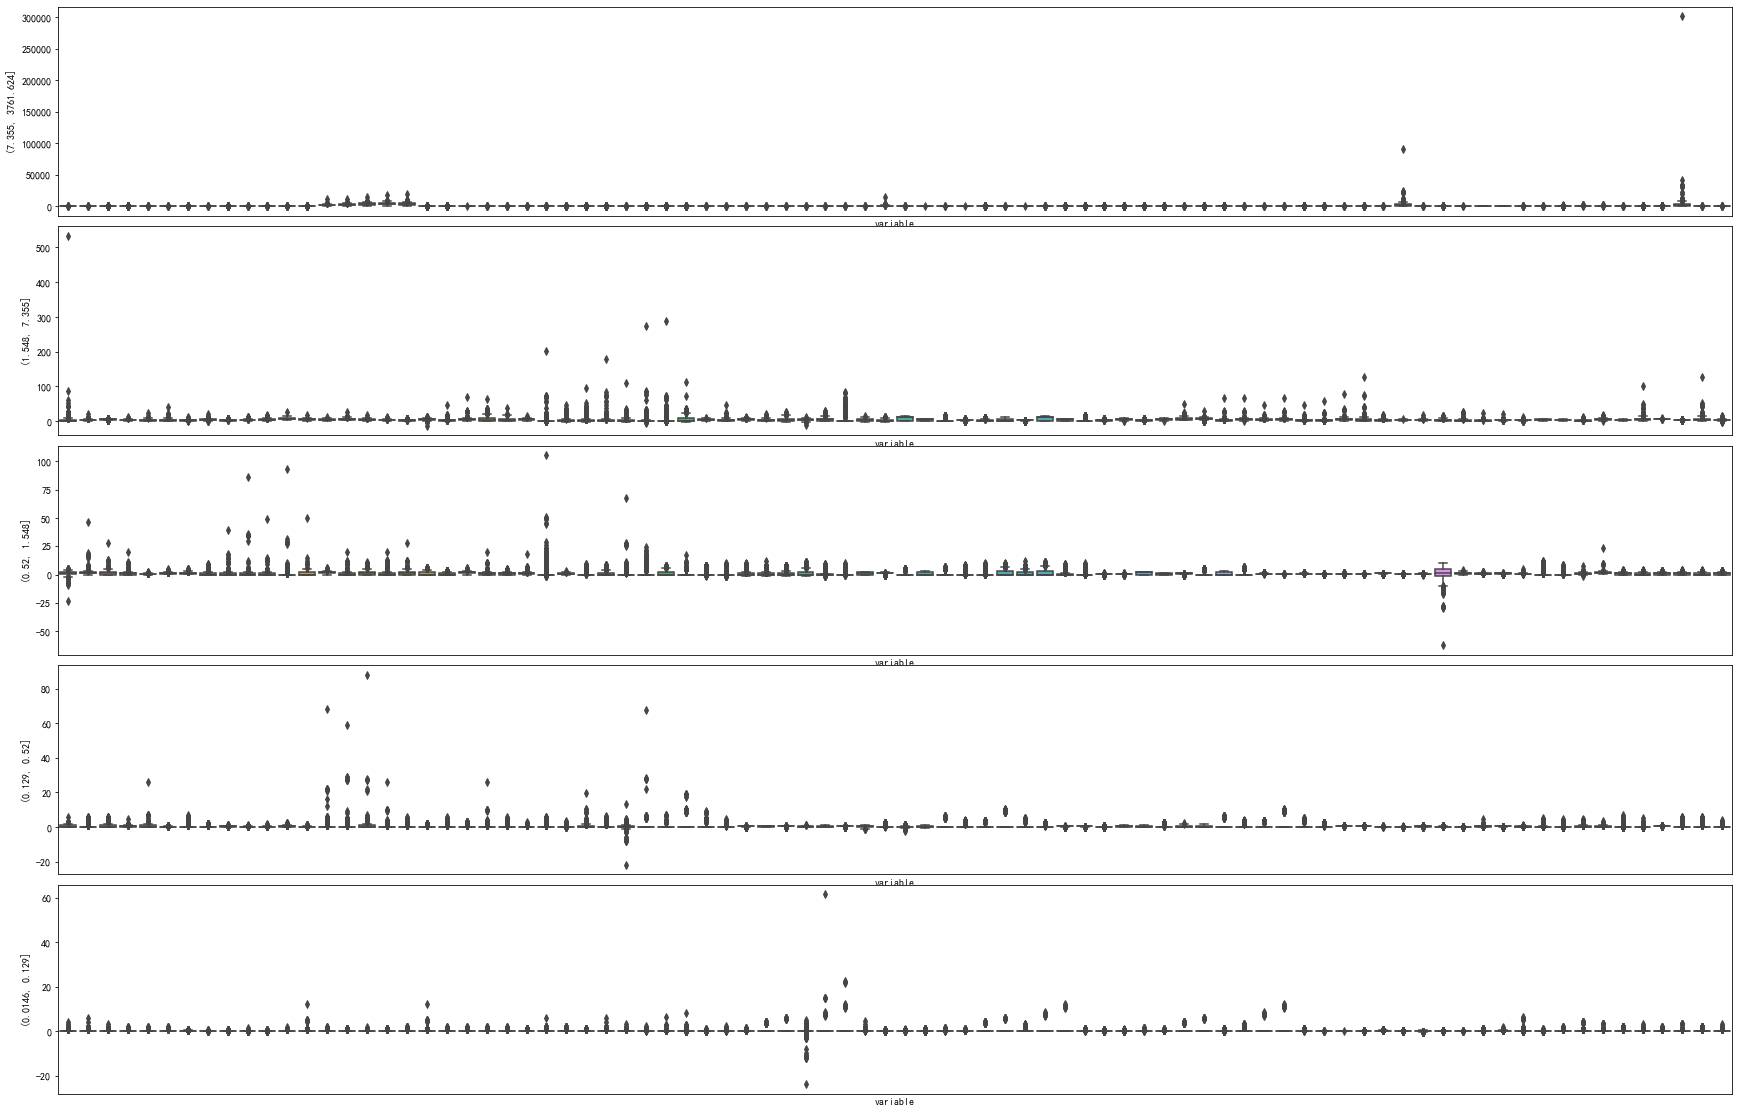

In [13]:
# 数据分布箱线图（未进行标准化）
bins = 5
cat = pd.qcut(rawdata2.drop(["SMILES","pIC50"],axis=1).mean(axis=0),6,duplicates="drop")
cat2 = pd.DataFrame(cat,columns=["interval"])

fig=plt.figure(figsize=(30,20))
plt.rcParams['boxplot.flierprops.markersize'] = 4 # 默认为6
for i in range(bins):
    ax=fig.add_subplot(bins,1,i+1)
    
    varlist = cat2.loc[cat2["interval"]==cat.value_counts().index[i],:].index
    score_plotdata = rawdata2.loc[:,varlist].melt()

#     ax.boxplot(rawdata2.loc[:,varlist])
    
    color_p = sns.color_palette("Reds",9)
    sns.boxplot(x="variable", y="value",data=score_plotdata)
    
    ax.grid(linestyle="-.", axis='x', alpha=0.4)
    ax.set_xticks([])
    ax.set_ylabel(cat.value_counts().index[i])

plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig("./output/数据分布箱线图（未进行标准化）.png",dpi=500, bbox_inches = "tight")
plt.show()

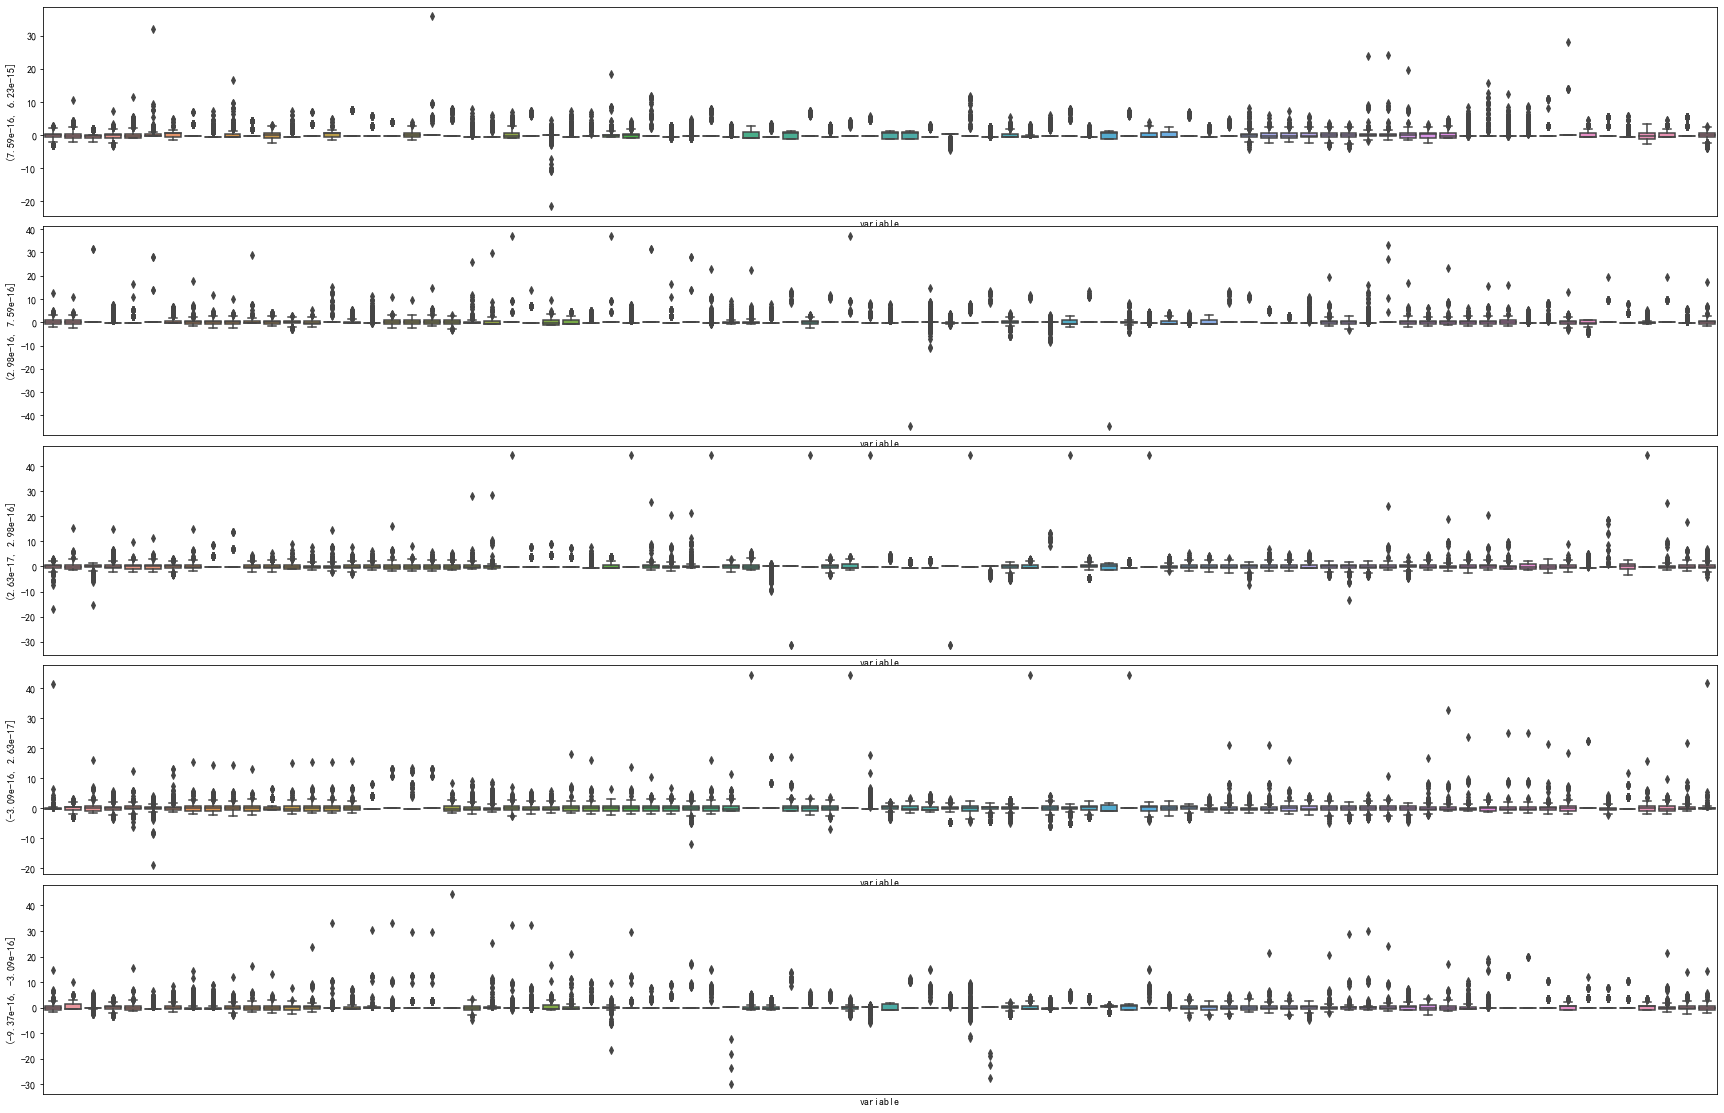

In [14]:
# 数据标准化（此处使用的数据已经经过异常值处理）
zscore = preprocessing.StandardScaler()
data_scale = zscore.fit_transform(rawdata2.drop(labels=["SMILES","pIC50"],axis=1))

x_train = data_scale
y_train = rawdata2.loc[:,"pIC50"].values

features = rawdata2.drop(labels=["SMILES","pIC50"],axis=1).columns

train2 = pd.DataFrame(x_train,columns=features,index=rawdata2["SMILES"])
train2["pIC50"] = y_train



# 数据分布箱线图（标准化后数据）
bins = 5
cat = pd.qcut(train2.drop(labels=["pIC50"],axis=1).mean(axis=0),6,duplicates="drop")
cat2 = pd.DataFrame(cat,columns=["interval"])

fig=plt.figure(figsize=(30,20))
plt.rcParams['boxplot.flierprops.markersize'] = 4 # 默认为6
for i in range(bins):
    ax=fig.add_subplot(bins,1,i+1)
    
    varlist = cat2.loc[cat2["interval"]==cat.value_counts().index[i],:].index
    score_plotdata = train2.loc[:,varlist].melt()

#     ax.boxplot(train2.loc[:,varlist])
    
    color_p = sns.color_palette("Reds",9)
    sns.boxplot(x="variable", y="value",data=score_plotdata)
    
    ax.grid(linestyle="-.", axis='x', alpha=0.4)
    ax.set_xticks([])
    ax.set_ylabel(cat.value_counts().index[i])

plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig("./output/变量箱线图可视化-异常值处理后-标准化后数据.png",dpi=500, bbox_inches = "tight")
plt.show()


In [15]:
# 秩相关过滤（线性相关系数不适用）
# def multivariate_pearsonr(X, Y): 
#     scores, pvalues = [], []
#     for column in range(X.shape[1]):
#         cur_score, cur_p = kendalltau(X[:,column], Y)
#         scores.append(abs(cur_score))
#         pvalues.append(cur_p)
#     return (np.array(scores), np.array(pvalues))

# m_pearson = SelectKBest(score_func=multivariate_pearsonr,k="all")
# m_pearson.fit_transform(x_train,y_train)
# pearson = pd.DataFrame(m_pearson.scores_, columns = ["PearsonCorr"], index=features)
# pearson = pearson.reset_index()
# pearson.sort_values('PearsonCorr',ascending=0)


In [16]:
# 方差过滤
vt = VarianceThreshold()
vt.fit_transform(x_train)
var_thd = pd.DataFrame(vt.variances_, columns = ["Variance"], index=features)
var_thd = var_thd.reset_index()
var_thd.sort_values('Variance',ascending=0)

# F检验过滤
f_model = SelectKBest(score_func=f_regression , k="all")
f_model.fit(x_train,y_train)
f_reg = pd.DataFrame(f_model.scores_, columns = ["FTest"], index=features)
f_reg = f_reg.reset_index()
f_reg.sort_values('FTest',ascending=0)

# 互信息过滤
test = SelectKBest(score_func=mutual_info_regression , k="all")
test.fit(x_train,y_train)
mutual_info = pd.DataFrame(test.scores_, columns = ["MutuaInfo"], index=features)
mutual_info = mutual_info.reset_index()
mutual_info.sort_values('MutuaInfo',ascending=0)

# Pearson相关过滤（线性相关系数不适用）
# def multivariate_pearsonr(X, Y): 
#     scores, pvalues = [], []
#     for column in range(X.shape[1]):
#         cur_score, cur_p = pearsonr(X[:,column], Y)
#         scores.append(abs(cur_score))
#         pvalues.append(cur_p)
#     return (np.array(scores), np.array(pvalues))

# m_pearson = SelectKBest(score_func=multivariate_pearsonr,k="all")
# m_pearson.fit_transform(x_train,y_train)
# pearson = pd.DataFrame(m_pearson.scores_, columns = ["PearsonCorr"], index=features)
# pearson = pearson.reset_index()
# pearson.sort_values('PearsonCorr',ascending=0)

def GRA_ONE(DataFrame,m=0):
    gray= DataFrame

    std=gray.iloc[:,m]#为标准要素
    ce=gray.iloc[:,0:]#为比较要素
    n=ce.shape[0]
    m=ce.shape[1]#计算行列

    a=zeros([m,n])
    for i in range(m):
        for j in range(n):
            a[i,j]=abs(ce.iloc[j,i]-std[j])

    c=amax(a)
    d=amin(a)

    result=zeros([m,n])
    for i in range(m):
        for j in range(n):
            result[i,j]=(d+0.5*c)/(a[i,j]+0.5*c)

    result2=zeros(m)
    for i in range(m):
            result2[i]=mean(result[i,:])
    RT=pd.DataFrame(result2)
    return RT

gra = GRA_ONE(train2,m=train2.shape[1]-1)

gra_res = pd.DataFrame(gra.iloc[:-1,0].values, columns = ["GRA"], index=features)
gra_res = gra_res.reset_index()
gra_res.sort_values('GRA',ascending=0)

# 决策树
DT = DecisionTreeRegressor(random_state=1234)
DT.fit(x_train,y_train)
DT_inportance = pd.DataFrame(DT.feature_importances_, columns = ["DecisionTree"], index=features)
DT_inportance = DT_inportance.reset_index()
DT_inportance.sort_values(['DecisionTree'],ascending=0)

# XGBoost
xgboost = XGBRegressor(random_state=1234)
xgboost.fit(x_train,y_train)
xgboost_inportance = pd.DataFrame(xgboost.feature_importances_, columns = ["XGBoost"], index=features)
xgboost_inportance = xgboost_inportance.reset_index()
xgboost_inportance.sort_values(['XGBoost'],ascending=0)


# 随机森林变量重要性
forest = RandomForestRegressor(random_state=1234)
forest.fit(x_train, y_train)
RF_inportance = pd.DataFrame(forest.feature_importances_, columns = ["RandomForest"], index=features)
RF_inportance = RF_inportance.reset_index()
RF_inportance.sort_values(['RandomForest'],ascending=0)


# 极端随机树分类器
model = ExtraTreesRegressor(random_state=1234)
model.fit(x_train,y_train)
ET = pd.DataFrame(model.feature_importances_, columns = ["ExtraTrees"], index=features)
ET = ET.reset_index()
ET.sort_values(['ExtraTrees'],ascending=0)


# Lasso 正则化(系数取绝对值)
lasso = Lasso(alpha=0.00001,random_state=1234)
lasso.fit(x_train,y_train)  
lasso_res = pd.DataFrame(np.abs(lasso.coef_), columns = ["Lasso"], index=features)
lasso_res = lasso_res.reset_index()
# lasso_res.sort_values('Lasso',ascending=0)


In [17]:
# 融合
all_res = [var_thd,f_reg,mutual_info,gra_res,DT_inportance,
           xgboost_inportance,RF_inportance,ET,lasso_res]
final_results = reduce(lambda left, right: pd.merge(left,
                                                   right,
                                                   on='index',
                                                   how='outer'),all_res)
final_results2 = final_results.loc[final_results["Variance"]>0,:]
final_results2.to_csv("./output/各方法的变量重要性粗筛.csv")

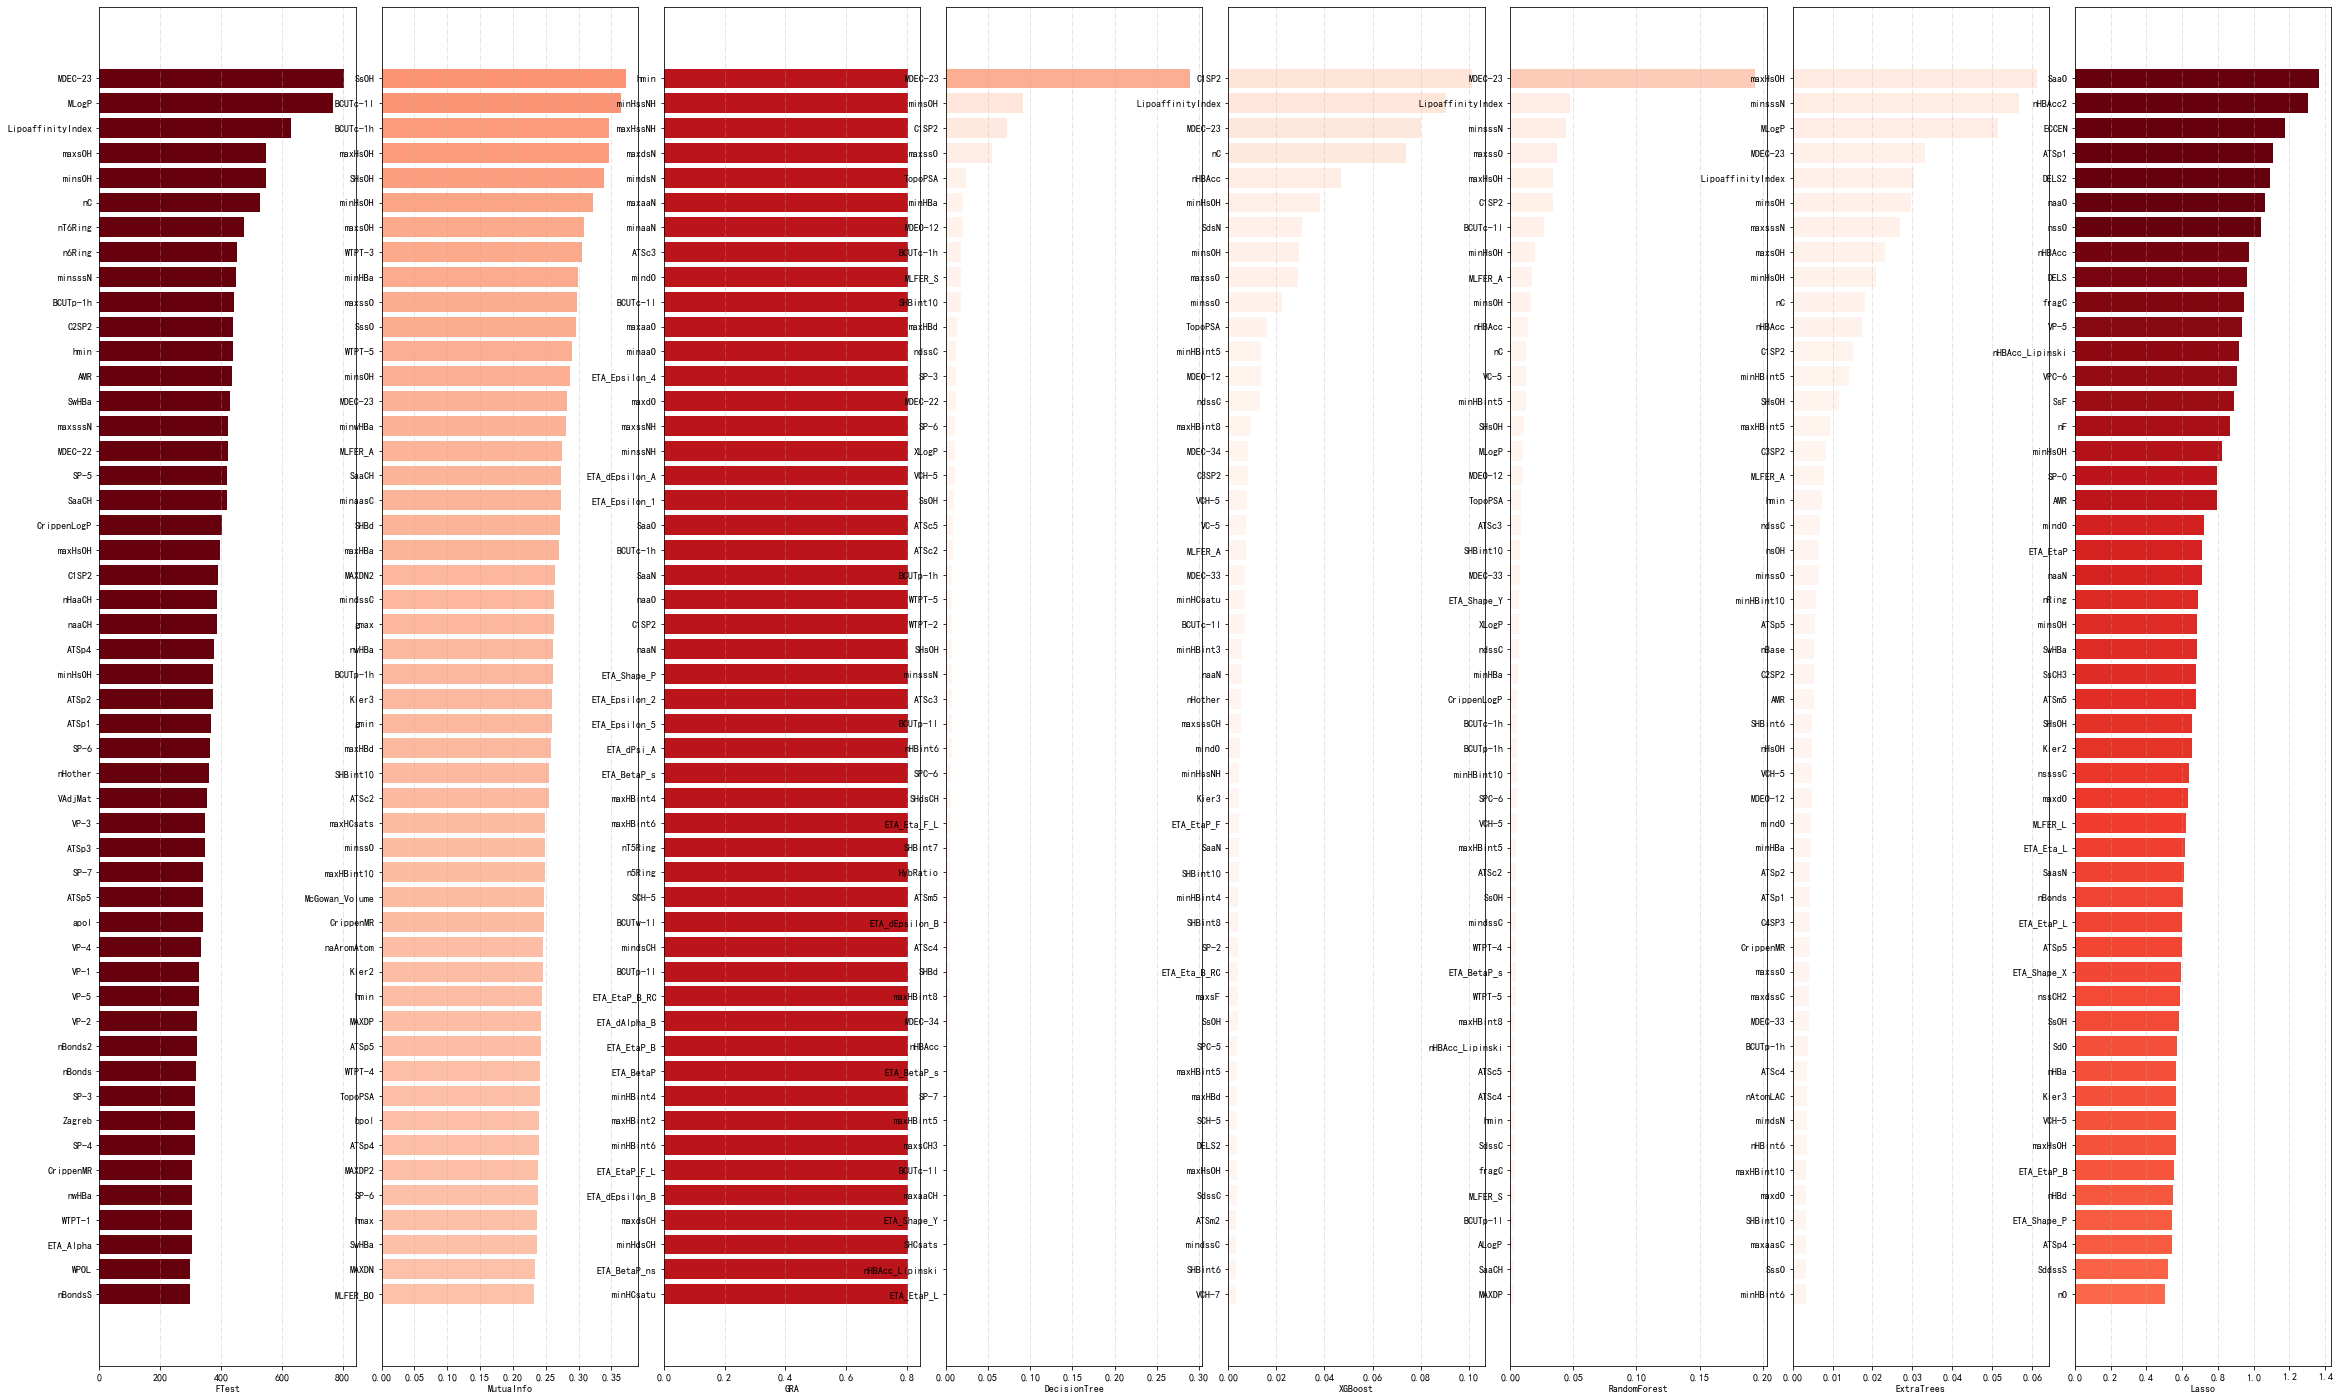

In [18]:
# 变量重要性可视化
fig=plt.figure(figsize=(40,25))
cols = final_results.columns.drop(["index","Variance"])
# plt.ylabel("Importance")

answer1 = dict()
for i in range(len(cols)):
    
    ax=fig.add_subplot(1,len(cols),i+1)
    
    final_results3 = final_results2.sort_values(cols[i],ascending=False).head(50)
    coef_dt_sort0 = final_results3.sort_values(cols[i],ascending=True)
    index_sort =  final_results3[cols[i]].sort_values().index
    coef_dt_sort = final_results3.loc[index_sort,:]
    answer1[cols[i]] = coef_dt_sort['index'].values

    x, y = coef_dt_sort['index'], coef_dt_sort[cols[i]]
    map_vir = cm.get_cmap(name="Reds")

    color = map_vir(coef_dt_sort0[cols[i]])
    ax.barh(x, y, color=color,label=cols[i])
    
    ax.grid(linestyle="-.", axis='x', alpha=0.4)
    ax.set_xlabel(cols[i])

plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig("./output/变量重要性可视化.png",dpi=500, bbox_inches = "tight")
plt.show()

In [19]:
answer1_res=pd.DataFrame(answer1)
answer1_res.to_csv("./output/问题一各方法重要性排序变量.csv")
# answer1
# coef_dt_sort['index'].values
answer1_res

PermissionError: [Errno 13] Permission denied: './output/问题一各方法重要性排序变量.csv'

In [ ]:
# 最终变量选择结果
methods = final_results.columns.drop(["index","Variance"])
sort_var = dict()
for m in methods:
    sort_var[m] = final_results2.sort_values(m,ascending=False).head(50)["index"].values
    

select_all = pd.DataFrame(sort_var)
select_all2 = select_all.melt().value_counts("value")
selec = select_all2.head(20)  # 综合选择的前20个变量
print(selec.index)
select_data_final = desc_detail2.loc[desc_detail2["Descriptor"].isin(selec.index.to_list()),:]
select_data_final.to_csv("./output/第一问选择的变量.csv ")
# Index(['minsOH', 'LipoaffinityIndex', 'MDEC-23', 'minHsOH', 'nC', 'maxssO',
#        'C1SP2', 'BCUTp-1h', 'BCUTc-1l', 'fragC', 'hmin', 'maxHBd', 'maxHsOH',
#        'SHsOH', 'TopoPSA', 'SaaCH', 'MLogP', 'MLFER_A', 'MDEO-12', 'SHBint10'],
#       dtype='object', name='value')
# print(selec)
# Index(['minsOH', 'C1SP2', 'maxHsOH', 'MDEC-23', 'minHsOH', 'nC', 'SsOH',
#        'BCUTp-1h', 'BCUTc-1l', 'nHBAcc', 'VCH-5', 'SHsOH', 'SHBint10',
#        'maxssO', 'hmin', 'mindO', 'TopoPSA', 'LipoaffinityIndex', 'maxHBint5',
#        'MDEO-12'],
#       dtype='object', name='value')

In [ ]:
# 建立模型
X = train2.loc[:,selec.index.tolist()]

# xx = RF_inportance.sort_values(by="RandomForest",ascending=False).head(20)["index"].values
# X = train2.loc[:,xx.tolist()]



print(X.shape)
y = train2.loc[:,"pIC50"]
# 划分数据集(可能需要按照时间顺序划分Train、Test)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1234,test_size=0.2)


In [ ]:
# 测试结果数据标准化
zscore = preprocessing.StandardScaler()
datatest_scale = zscore.fit_transform(testrawdata.drop(labels=["SMILES","pIC50"],axis=1))

X_resdata = datatest_scale
testfeatures = testrawdata.drop(labels=["SMILES","pIC50"],axis=1).columns

datatest = pd.DataFrame(X_resdata,columns=testfeatures,index=testrawdata["SMILES"])
X_resdata = datatest.loc[:,selec.index.tolist()]
X_resdata.shape

In [ ]:
## 下面的模型都存在严重过拟合问题
# 各个模型的交叉验证
models = {
    "Random Forest":RandomForestRegressor(random_state=1234, n_estimators=300),
    "XGBoost":XGBRegressor(),
    "AdaBoost":AdaBoostRegressor(),
    "GradientBoost":GradientBoostingRegressor(),
    "MLP":MLPRegressor(),
    "SVR_rbf":SVR(gamma='auto', kernel='rbf'),
    "Bagging":BaggingRegressor(),
    "Bag_KNN":BaggingRegressor(KNeighborsRegressor(), max_samples=0.5, max_features=0.5),
    "NuSVR":NuSVR(gamma='auto')
}



scores_dict = {}
for name,model in models.items():

    cv = ShuffleSplit(n_splits=10, test_size=.3, random_state=0) 
    scores_CV = cross_val_score(model, X, y, cv=cv)  
#     print(name,":",scores_CV)
    scores_dict[name] = scores_CV  # 保存交叉验证评分结果
df_scoresCV = pd.DataFrame(scores_dict)
df_scoresCV.to_csv("./output/交叉验证得分结果.csv",index=False,header=True)


# 可视化绘制箱线图
score_plotdata = pd.DataFrame(scores_dict).melt()

plt.figure(figsize=(15,8))
# sns.set(style="white")
color_p = sns.color_palette("Reds",9)
sns.boxplot(x="variable", y="value",data=score_plotdata)
plt.xticks(rotation=90)
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")

plt.savefig("./output/交叉验证得分结果箱线图.png",dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
# 单个模型应用

In [ ]:
"""随机森林"""
rf = RandomForestRegressor(min_samples_leaf=2, 
                           min_samples_split=4,
                           n_estimators=300,
                           random_state=1234)
rf.fit(X_train,y_train)
print(rf)
print('Training set score:{:.2f}'.format(rf.score(X_train,y_train)))
print('Test set score:{:.2f}'.format(rf.score(X_test,y_test)))
print("Training set MSE:{:.2f}".format(mean_squared_error(y_train,rf.predict(X_train))))
print("Test set MSE:{:.2f}".format(mean_squared_error(y_test,rf.predict(X_test))))

# 残差图
plt.plot((rf.predict(X_test)-y_test), linewidth=0.5)
plt.axhline(y=0, c="k", ls="--", lw=1)
plt.xticks([])
plt.xlabel("Test Sample")
plt.ylabel("RandomForest Residual")
plt.savefig("./output/RandomForest模型拟合的残差图.png", dpi = 500,bbox_inches = "tight")
plt.show()

# 应用到测试数据
pIC50 = rf.predict(X_resdata)
IC50 = 1000000000 / (10 ** pIC50)

answer2 = pd.DataFrame({"SMILES":X_resdata.index,"IC50_nM":IC50,"pIC50":pIC50})
answer2.to_csv("./output/问题2结果-随机森林预测.csv")

In [25]:
2/3**2
2/9
2/(10**3)
2/10**3

0.002

In [ ]:
# """GBDT"""
# gbr = GradientBoostingRegressor(learning_rate=0.1,
#                                 max_depth=4,max_features="log2",
#                                 n_estimators=200,
#                                min_samples_split=2).fit(X_train,y_train)
# print('Training set score:{:.2f}'.format(gbr.score(X_train,y_train)))
# print('Test set score:{:.2f}'.format(gbr.score(X_test,y_test)))
# print("Training set MSE:{:.2f}".format(mean_squared_error(y_train,gbr.predict(X_train))))
# print("Test set MSE:{:.2f}".format(mean_squared_error(y_test,gbr.predict(X_test))))

# # 残差图
# plt.plot((gbr.predict(X_test)-y_test), linewidth=0.5)
# plt.axhline(y=0, c="k", ls="--", lw=1)
# plt.xticks([])
# plt.xlabel("Test Sample")
# plt.ylabel("GBDT Residual")
# plt.savefig("./output/GBDT模型拟合的残差图.png", dpi = 500, bbox_inches = "tight")
# plt.show()


In [ ]:
# """XGBoost"""
# xgb = XGBRegressor().fit(X_train,y_train)
# print('Training set score:{:.2f}'.format(xgb.score(X_train,y_train)))
# print('Test set score:{:.2f}'.format(xgb.score(X_test,y_test)))
# print("Training set MSE:{:.2f}".format(mean_squared_error(y_train,xgb.predict(X_train))))
# print("Test set MSE:{:.2f}".format(mean_squared_error(y_test,xgb.predict(X_test))))

# # 残差图
# plt.plot((xgb.predict(X_test)-y_test), linewidth=0.5)
# plt.axhline(y=0, c="k", ls="--", lw=1)
# plt.xticks([])
# plt.xlabel("Test Sample")
# plt.ylabel("XGBoost Residual")
# plt.savefig("./output/XGBoost模型拟合的残差图.png", dpi = 500, bbox_inches = "tight")
# plt.show()

In [ ]:
# GBDT模型应用
gbrscoretest = []
gbrscoretrain = []
msetrain = []
msetest = []
for i in np.arange(0.001,0.1,0.001):
    gbr = GradientBoostingRegressor(learning_rate=i,
                                max_depth=11,max_features="log2",
                                n_estimators=200,
                               min_samples_split=3)
    gbr.fit(X_train,y_train)
    gbrscoretest.append(gbr.score(X_test,y_test))
    gbrscoretrain.append(gbr.score(X_train,y_train))
    msetrain.append(mean_squared_error(y_train,gbr.predict(X_train)))
    msetest.append(mean_squared_error(y_test,gbr.predict(X_test)))
    
    
    
    
gbr_res = pd.DataFrame({"iter":list(np.arange(0.01,1,0.01)),
                        "gbrscoretest":gbrscoretest,
                       "gbrscoretrain":gbrscoretrain,
                       "msetrain":msetrain,
                       "msetest":msetest})
plt.plot(gbr_res["iter"],gbr_res["gbrscoretest"],label="GBDT TestSet")
plt.plot(gbr_res["iter"],gbr_res["gbrscoretrain"],label="GBDT TrainSet")
plt.legend()
plt.show()

plt.plot(gbr_res["iter"],gbr_res["msetest"],label="GBDT TestSet")
plt.plot(gbr_res["iter"],gbr_res["msetrain"],label="GBDT TrainSet")
plt.legend()
plt.show()

# 问题3

In [ ]:
ADMET_y = ["Caco-2","CYP3A4","hERG","HOB","MN"]
# 模型字典
models = {
        "AdaBoost":AdaBoostClassifier(),
        "KNN":KNeighborsClassifier(),
        "Decision Tree":DecisionTreeClassifier(),
        "Logistic":LogisticRegression(),
        "GBDT":GradientBoostingClassifier(),
        "XGBoost":XGBClassifier(eval_metric=["logloss","auc","error"]),
        "SVM":SVC(probability=True),
        "Random Forest":RandomForestClassifier(),
        "MLP":MLPClassifier() 
        }

ycol_seldata = dict()
ycol_models = dict()
ycol_pred = dict()

In [ ]:
for ycol in ADMET_y:
    
    
    # 测试集数据标准化
    zscore = preprocessing.StandardScaler()
    ADMET_scale = zscore.fit_transform(concat_ADMET.drop(ADMET_y,axis=1))

    ADMETx_train = ADMET_scale
    ADMETy_train = concat_ADMET.loc[:,ycol].values

    features = concat_ADMET.drop(ADMET_y,axis=1).columns

    ADMETtrain = pd.DataFrame(ADMETx_train,columns=features,index=concat_ADMET.index)
    ADMETtrain[ycol] = ADMETy_train
    
    
     # 数据降维（根据随机森林计算的变量重要性筛选50个变量）
    forest = RandomForestClassifier(random_state=1234)
    forest.fit(ADMETtrain.drop(ycol,axis=1), ADMETtrain[ycol])
    RF_inportance = pd.DataFrame(forest.feature_importances_, columns = ["RandomForest"], index=features)
    RF_inportance = RF_inportance.reset_index()
    RF_inportance.sort_values(['RandomForest'],ascending=0)

    sel = RF_inportance.head(50)["index"].values.tolist() # 筛选的变量名
    ycol_seldata[ycol] = sel

    y = ADMETtrain.loc[:,ycol]
    X = ADMETtrain.loc[:,sel]

    
    
    # 划分数据集
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1234,test_size=0.2)
    
    
    
    # 多个模型交叉验证
    scores_dict = {}
    for name,model in models.items():

        cv = ShuffleSplit(n_splits=10, test_size=.3, random_state=0) 
        scores_CV = cross_val_score(model, X,y, cv=cv)
        print(name,":",scores_CV)
        scores_dict[name] = scores_CV  # 保存交叉验证评分结果
    df_scoresCV = pd.DataFrame(scores_dict).round(3)
    df_scoresCV.to_csv("./output/交叉验证得分结果_{}.csv".format(ycol),index=True,header=True)
    
    # 交叉验证可视化绘制箱线图
    score_plotdata = pd.DataFrame(scores_dict).melt()
    plt.figure(figsize=(15,10))
    color_p = sns.color_palette(colormap2,9)
    sns.boxplot(x="variable", y="value",data=score_plotdata,palette=color_p)
    plt.xticks(rotation=90)
    plt.xlabel("Machine Learning Models")
    plt.ylabel("Score")

    plt.savefig("./output/交叉验证得分结果箱线图_{}.png".format(ycol),dpi=500, bbox_inches = "tight")
    plt.show()
    
    
    
    # 建立各模型可视化结果
    fig, ax = plt.subplots(3,3,figsize=(20,15),sharey=True,sharex=True)

    flag = 0
    for name, model in models.items():

        clf = models[name].fit(X_train,y_train)
        train_predict = clf.predict(X_train)
        test_predict = clf.predict(X_test)

        # 利用热力图对于结果进行可视化
        confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
        sns.heatmap(confusion_matrix_result, annot=True, cmap=colormap2,fmt='.50g',ax=ax[flag//3,flag%3])

        ax[flag//3,flag%3].set_xlabel(name)
        ax[flag//3,flag%3].set_ylabel("True Value")
        flag +=1
    # plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig("./output/所有模型混淆矩阵图_{}.png".format(ycol),dpi=500,bbox_inches = "tight")
    plt.show()
    
    # AUC曲线排版1

    fig, ax = plt.subplots(3,3,figsize=(20,15),sharey=True,sharex=True)

    flag = 0
    for name, model in models.items():
    #     if name == "KNN" or name == "Decision Tree" or name == "XGBoost":
    #         continue
        clf = models[name].fit(X_train,y_train)
        y_score = clf.predict_proba(X_test)

        fpr,tpr,threshold = metrics.roc_curve(y_test,y_score[:,1],pos_label=1)
        roc_auc = metrics.auc(fpr,tpr)

        # 绘制ROC曲线
        ax[flag//3,flag%3].plot(fpr, tpr,lw=2,color="black", label='{}(area = {:.3f})'.format(name, roc_auc))

        ax[flag//3,flag%3].set_xlabel(name)

        ax[flag//3,flag%3].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--',alpha=0.5)
        ax[flag//3,flag%3].set_xlim([0.0, 1.0])
        ax[flag//3,flag%3].set_ylim([0.0, 1.05])
        ax[flag//3,flag%3].set_xlabel('False Positive Rate')
        ax[flag//3,flag%3].set_ylabel('True Positive Rate')
        ax[flag//3,flag%3].legend(loc="lower right")
        flag +=1

    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig("./output/所有模型ROC曲线图排版1_{}.png".format(ycol),dpi=500,bbox_inches = "tight")
    plt.show()


    # AUC曲线排版2
    plt.figure(figsize=(15,10))
    for name, model in models.items():
    #     if name == "KNN" or name == "Decision Tree" or name == "XGBoost":
    #         continue
        clf = models[name].fit(X_train,y_train)
        y_score = clf.predict_proba(X_test)

        fpr,tpr,threshold = metrics.roc_curve(y_test,y_score[:,1],pos_label=1)
        roc_auc = metrics.auc(fpr,tpr)

        # 绘制ROC曲线
        plt.plot(fpr, tpr,lw=2, label='{}(AUC = {:.3f})'.format(name, roc_auc))

    plt.plot([0, 1], [0, 1], color="k", lw=1, linestyle='--',alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    # plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig("./output/所有模型ROC曲线图排版2_{}.png".format(ycol),dpi=500,bbox_inches = "tight")
    plt.show()
    
    
    # 模型应用到测试集
    model = df_scoresCV.mean(axis=0)[df_scoresCV.mean(axis=0)==df_scoresCV.mean(axis=0).max()].index[0]
    print("model:",models[model])  # 选择的优模型
    ycol_models[ycol] = models[model]
    
    # 测试结果数据标准化
    zscore = preprocessing.StandardScaler()
    ADMETtest_scale = zscore.fit_transform(concat_ADMET_test.drop(ADMET_y,axis=1))
    X_resdata = ADMETtest_scale
    testfeatures = concat_ADMET_test.drop(ADMET_y,axis=1).columns

    datatest = pd.DataFrame(X_resdata,columns=testfeatures,index=testrawdata["SMILES"])
    X_resdata = datatest.loc[:,sel]

    clf = models[model].fit(X_train,y_train)
    y_predict = clf.predict(X_resdata)
    ycol_pred[ycol] = y_predict
    

In [ ]:
answer3 = pd.DataFrame(ycol_pred,index=X_resdata.index)

res3_seldata = pd.DataFrame(ycol_seldata)
res3_seldata.to_csv("./output/问题三各因变量选择变量.csv",index=True,header=True)


answer3.to_csv("./output/问题三预测结果数据.csv",index=True,header=True)


In [ ]:
print(ycol_models)